In [84]:
import datetime
import json
import pandas as pd

# Define a dictionary to map sleep stage values to their corresponding labels
sleep_stage_labels = {
    1: "Awake (during sleep cycle)",
    2: "Sleep",
    3: "Out-of-bed",
    4: "Light sleep",
    5: "Deep sleep",
    6: "REM"
}

# Read sleep segment data from file
data = pd.read_json("..\Fit\All Data\derived_com.google.sleep.segment_com.google.an.json")
sleep_segments = data["Data Points"]

# Convert Epoch time to datetime objects and adjust dates
for segment in sleep_segments:
    start_time = datetime.datetime.fromtimestamp(int(segment["startTimeNanos"]) / 1e9)
    end_time = datetime.datetime.fromtimestamp(int(segment["endTimeNanos"]) / 1e9)
    if end_time.hour >= 16:
        segment_date = end_time.date()
    else:
        segment_date = start_time.date()
    segment["start_time"] = start_time
    segment["end_time"] = end_time
    segment["date"] = segment_date

# Calculate duration of each sleep segment in hours
for segment in sleep_segments:
    duration = (segment["end_time"] - segment["start_time"]).total_seconds() / 3600
    segment["duration"] = duration

# Group sleep segments by date and sum durations for each sleep stage
totals = {}
for segment in sleep_segments:
    date = segment["date"]
    sleep_stage = segment["fitValue"][0]["value"]["intVal"]
    if date not in totals:
        totals[date] = {label: 0 for label in sleep_stage_labels.values()}
    totals[date][sleep_stage_labels[sleep_stage]] += segment["duration"]

# Create a pandas DataFrame with date and hours slept for each sleep stage
df = pd.DataFrame.from_dict(totals, orient='index')
df.index.name = 'Date'
df.reset_index(inplace=True)

# Add a Total column to the DataFrame
df["Total"] = df.iloc[:, 1:].sum(axis=1)

# Calculate actual sleep time by subtracting "Awake" duration from "Total" duration
df["Actual Sleep Time"] = df["Total"] - df["Awake (during sleep cycle)"]

# Move "Actual Sleep Time" column to the left of "Total" column
df = df[["Date", "Awake (during sleep cycle)", "Sleep", "Out-of-bed", "Light sleep", "Deep sleep", "REM", "Actual Sleep Time", "Total"]]

# Sort the dataframe by date
df = df.sort_values(by="Date")

# Calculate the start and end times for each date
schedule = {}
for segment in sleep_segments:
    date = segment["date"]
    start_time = segment["start_time"].time()
    end_time = segment["end_time"].time()

    if end_time.hour >= 16:
        if date not in schedule:
            schedule[date] = {"start_time": start_time, "end_time": end_time}
        else:
            if start_time < schedule[date]["start_time"]:
                schedule[date]["start_time"] = start_time
    else:
        previous_date = date - datetime.timedelta(days=1)
        previous_date_str = previous_date.strftime("%Y-%m-%d")
        if previous_date_str not in schedule:
            schedule[previous_date_str] = {"start_time": start_time, "end_time": end_time}
        else:
            if end_time > schedule[previous_date_str]["end_time"]:
                schedule[previous_date_str]["end_time"] = end_time

# Create a DataFrame for the sleep schedule
schedule_df = pd.DataFrame.from_dict(schedule, orient='index')
schedule_df.index.name = 'Date'
schedule_df.reset_index(inplace=True)

# Merge the sleep schedule DataFrame with the main DataFrame
df = pd.merge(df, schedule_df, on='Date', how='left')

print(df)

            Date  Awake (during sleep cycle)  Sleep  Out-of-bed  Light sleep   
0     2019-07-28                    0.066667    0.0           0     0.958333  \
1     2019-07-29                    0.983333    0.0           0     3.691667   
2     2019-07-30                    0.783333    0.0           0     5.158333   
3     2019-07-31                    0.566667    0.0           0     3.675000   
4     2019-08-01                    0.008333    0.0           0     0.991667   
...          ...                         ...    ...         ...          ...   
1043  2023-04-27                    0.716667    0.0           0     4.133333   
1044  2023-04-28                    0.900000    0.0           0     5.366667   
1045  2023-04-29                    1.133333    0.0           0     6.650000   
1046  2023-04-30                    0.049999    0.0           0     0.916665   
1047  2023-05-01                    0.533327    0.0           0     4.566658   

      Deep sleep       REM  Actual Slee

In [91]:
df['Date'] = pd.to_datetime(df['Date'])
df_filtered = df[df['Date'].dt.year == 2022].head(100)
df_filtered

,Date,Awake (during sleep cycle),Sleep,Out-of-bed,Light sleep,Deep sleep,REM,Actual Sleep Time,Total,start_time,end_time
751,2022-01-01,0.616667,0.0,0,3.633333,1.458333,1.383333,6.475000,7.091667,NaN,NaN
752,2022-01-02,0.433333,0.0,0,4.858333,1.775000,2.500000,9.133333,9.566667,23:56:30,23:57:00
753,2022-01-03,0.725000,0.0,0,7.183333,1.966667,2.608333,11.758333,12.483333,NaN,NaN
754,2022-01-04,0.583333,0.0,0,3.483333,1.400000,0.858333,5.741667,6.325000,23:52:30,23:53:00
755,2022-01-05,0.675000,0.0,0,4.250000,2.408333,1.866667,8.525000,9.200000,23:00:30,23:06:30
...,...,...,...,...,...,...,...,...,...,...,...
846,2022-04-10,0.916667,0.0,0,4.375000,1.750000,1.908333,8.033333,8.950000,NaN,NaN
847,2022-04-11,0.433333,0.0,0,4.225000,1.325000,1.658333,7.208333,7.641667,NaN,NaN
848,2022-04-12,0.325000,0.0,0,4.750000,1.966667,2.275000,8.991667,9.316667,23:22:00,23:42:00
849,2022-04-13,0.533333,0.0,0,5.250000,1.191667,2.491667,8.933333,9.466667,NaN,NaN


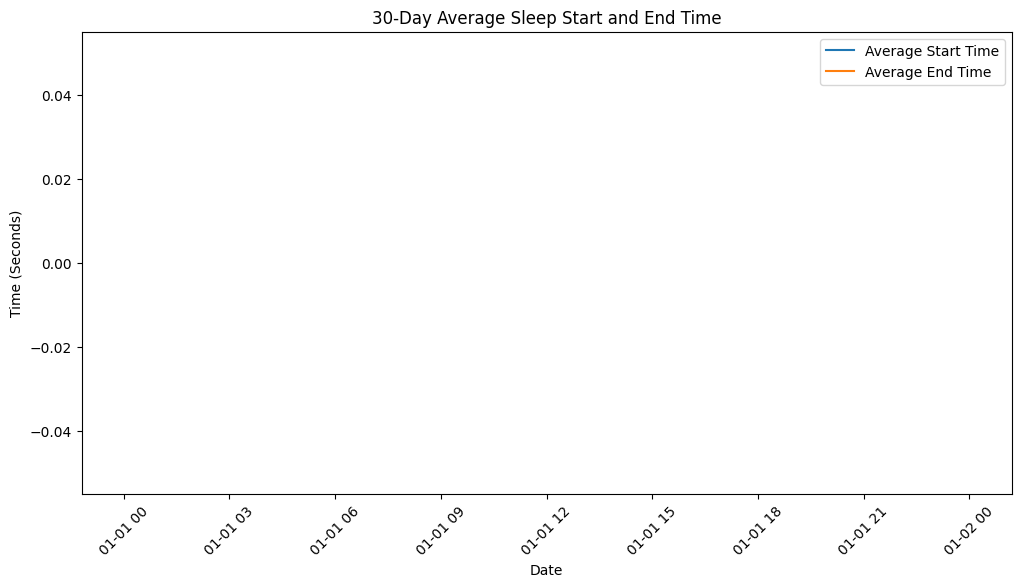

In [78]:
# Convert start and end times to time in seconds
df["Start Time (Seconds)"] = pd.to_datetime(df["start_time"], errors='coerce').dt.hour * 3600 + pd.to_datetime(df["start_time"], errors='coerce').dt.minute * 60 + pd.to_datetime(df["start_time"], errors='coerce').dt.second
df["End Time (Seconds)"] = pd.to_datetime(df["end_time"], errors='coerce').dt.hour * 3600 + pd.to_datetime(df["end_time"], errors='coerce').dt.minute * 60 + pd.to_datetime(df["end_time"], errors='coerce').dt.second

# Calculate the 30-day rolling average between sleep start and sleep end time
df["Average Start Time"] = df["Start Time (Seconds)"].rolling(window=30, min_periods=1).mean()
df["Average End Time"] = df["End Time (Seconds)"].rolling(window=30, min_periods=1).mean()

# Plot the 30-day average start and end times
plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["Average Start Time"], label="Average Start Time")
plt.plot(df["Date"], df["Average End Time"], label="Average End Time")
plt.xlabel("Date")
plt.ylabel("Time (Seconds)")
plt.title("30-Day Average Sleep Start and End Time")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [72]:
schedule_df

,Date,start_time,end_time
0,2021-03-12,08:20:30,14:01:30
1,2021-03-13,00:43:30,11:38:30
2,2021-03-14,23:26:30,23:27:00
3,2021-03-14,00:26:00,14:18:00
4,2021-03-15,04:44:00,13:17:30
...,...,...,...
1450,2021-03-08,02:51:00,11:37:00
1451,2021-03-09,05:17:00,15:01:30
1452,2021-03-11,23:13:00,23:13:30
1453,2021-03-10,23:58:30,00:22:30


In [79]:
import datetime
import json
import pandas as pd
import matplotlib.pyplot as plt

# Define a dictionary to map sleep stage values to their corresponding labels
sleep_stage_labels = {
    1: "Awake (during sleep cycle)",
    2: "Sleep",
    3: "Out-of-bed",
    4: "Light sleep",
    5: "Deep sleep",
    6: "REM"
}

# Read sleep segment data from file
data = pd.read_json("..\Fit\All Data\derived_com.google.sleep.segment_com.google.an.json")
sleep_segments = data["Data Points"]

# Convert Epoch time to datetime objects and adjust dates
for segment in sleep_segments:
    start_time = datetime.datetime.fromtimestamp(int(segment["startTimeNanos"]) / 1e9)
    end_time = datetime.datetime.fromtimestamp(int(segment["endTimeNanos"]) / 1e9)
    if end_time.hour >= 16:
        segment_date = end_time.date()
    else:
        segment_date = start_time.date()
    segment["start_time"] = start_time
    segment["end_time"] = end_time
    segment["date"] = segment_date

# Calculate duration of each sleep segment in hours
for segment in sleep_segments:
    duration = (segment["end_time"] - segment["start_time"]).total_seconds() / 3600
    segment["duration"] = duration

# Group sleep segments by date and sum durations for each sleep stage
totals = {}
for segment in sleep_segments:
    date = segment["date"]
    sleep_stage = segment["fitValue"][0]["value"]["intVal"]
    if date not in totals:
        totals[date] = {label: 0 for label in sleep_stage_labels.values()}
    totals[date][sleep_stage_labels[sleep_stage]] += segment["duration"]

# Create a pandas DataFrame with date and hours slept for each sleep stage
df = pd.DataFrame.from_dict(totals, orient='index')
df.index.name = 'Date'
df.reset_index(inplace=True)

# Add a Total column to the DataFrame
df["Total"] = df.iloc[:, 1:].sum(axis=1)

# Calculate actual sleep time by subtracting "Awake" duration from "Total" duration
df["Actual Sleep Time"] = df["Total"] - df["Awake (during sleep cycle)"]

# Sort the dataframe by date
df = df.sort_values(by="Date")

# Convert start_time and end_time columns to datetime type
df["start_time"] = pd.to_datetime(df["start_time"])
df["end_time"] = pd.to_datetime(df["end_time"])

# Calculate the 30-day rolling average between sleep start and sleep end time
df["Sleep Start Time"] = df["start_time"].dt.hour * 3600 + df["start_time"].dt.minute * 60 + df["start_time"].dt.second
df["Sleep End Time"] = df["end_time"].dt.hour * 3600 + df["end_time"].dt.minute * 60 + df["end_time"].dt.second
df["Rolling Average"] = df["Sleep Start Time"].rolling(window=30).mean()

# Plot the rolling average sleep start and sleep end time
plt.figure(figsize=(10, 6))
plt.plot(df["Date"], df["Rolling Average"], marker='o')
plt.xlabel("Date")
plt.ylabel("Sleep Time (Seconds)")
plt.title("30-Day Average Sleep Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


KeyError: 'start_time'